In [9]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES=0
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0


In [2]:
%autoreload 2
from graph_augmented_pt.utils.tensorboard_utils import *

from graphlet_atlas import *
from synthetic_datasets import *
from synthetic_runner import *

import matplotlib, pandas as pd
%matplotlib inline

import copy, itertools, json, logging, os, pickle, scipy, shutil, time, numpy as np
from pathlib import Path
from IPython.display import Image 

# Generating Synthetic Data
## Cliques

In [3]:
DO_SUBSAMPLE = True

RAW_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2.txt'
PKL_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_feat.pkl'

SUBSAMPLE_FILEPATH_TEXT    = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_small.txt'
SUBSAMPLE_FILEPATH_DERIVED = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_feat_small.pkl'

assert os.path.isfile(RAW_FILEPATH) and os.path.isfile(PKL_FILEPATH)
assert os.path.isfile(SUBSAMPLE_FILEPATH_TEXT) and os.path.isfile(SUBSAMPLE_FILEPATH_DERIVED)

# Source: https://www.kaggle.com/mikeortman/wikipedia-sentences
with open(SUBSAMPLE_FILEPATH_TEXT if DO_SUBSAMPLE else RAW_FILEPATH, mode='r') as f: text_data = f.readlines()

with open(SUBSAMPLE_FILEPATH_DERIVED if DO_SUBSAMPLE else PKL_FILEPATH, mode='rb') as f:
    X, LDA, topics, first_topic, sents_by_topic, topic_correlations = pickle.load(f)

In [4]:
D = DisconnectedCliquesDataset(
    source_topic_probabilities = topics,
    source_sents_by_topic      = sents_by_topic,
    dataset_size               = 50,
    seed                       = 1,
    topic_thresh               = 0.9,
    total_topics               = 10,
    batch_size                 = 150,
    noise_rate                 = 0,
    noise_style                = 'random_add',
)

{'Topics': (1.0, 0.0)}


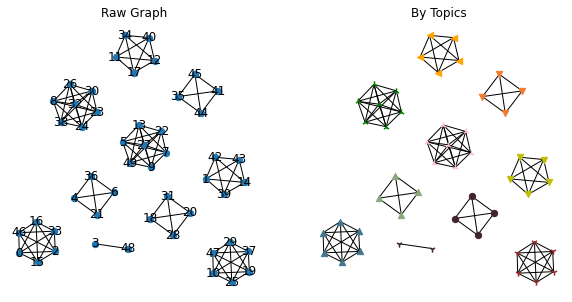

In [5]:
print(D.homophily_measure()[0])
D.display(do_print=False)

In [ ]:
logging.getLogger('lightning').setLevel(logging.ERROR)

DO_OVERWRITE       = False
results            = {}
dataset_seeds_all  = {}
model_metadata_all = {}
models_all         = {}

exp_dir = Path(
    "/crimea/graph_augmented_pt/runs/synthetic_reproductions/debug_cliques_v2"
)
if not exp_dir.exists(): os.makedirs(exp_dir)

dataset_size = 50

for noise_rate in tqdm((0, 0.05, 0.1, 0.15, 0.5), desc="Noise Rate", leave=False):
    graph_gen_kwargs = dict(
        source_topic_probabilities = topics,
        source_sents_by_topic      = sents_by_topic,
        dataset_size               = dataset_size,
        seed                       = 1,
        topic_thresh               = 0.9,
        total_topics               = 10,
        batch_size                 = 150,
        noise_rate                 = noise_rate,
        noise_style                = 'random_add'
    )

    output_dir_base = (
        exp_dir / graph_gen_kwargs['noise_style'] / f"dataset_size_{graph_gen_kwargs['dataset_size']}" / 
        f"noise_rate_{graph_gen_kwargs['noise_rate']}" / f"total_topics_{graph_gen_kwargs['total_topics']}"
    )
    if not output_dir_base.exists(): os.makedirs(output_dir_base)
        
    results[noise_rate]            = {}
    dataset_seeds_all[noise_rate]  = {}
    model_metadata_all[noise_rate] = {}
    models_all[noise_rate]         = {}

    gml_head = EUCLIDEAN_DISTANCE
    for gml_weight in tqdm((0.1, 0), desc="GML Weight", leave=False):
        point_weight = 1 - gml_weight

        times = [("Start", time.time())]

        output_dir = output_dir_base / gml_head / f"gml_weight_{gml_weight}"
        results_filepath = output_dir / "run_stats.json"
        mm_filepath = output_dir / 'model_metadata.json'
        ds_filepath = output_dir / 'dataset_seeds.json'
        models_filepath = output_dir / 'models.json'

        if os.path.isdir(output_dir):
            if (
                results_filepath.exists() and mm_filepath.exists() and ds_filepath.exists()
                and models_filepath.exists()
            ):
                with open(results_filepath, mode='r') as f:
                    results[noise_rate][gml_weight] = (json.loads(f.read()), None)
                with open(mm_filepath, mode='r') as f:
                    model_metadata_all[noise_rate][gml_weight] = (json.loads(f.read()), None)
                with open(ds_filepath, mode='r') as f:
                    dataset_seeds_all[noise_rate][gml_weight] = (json.loads(f.read()), None)
                with open(models_filepath, mode='rb') as f:
                    try: models_all[noise_rate][gml_weight] = pickle.load(f)
                    except: models_all[noise_rate][gml_weight] = None
                continue

            if DO_OVERWRITE: 
                print(f"Overwriting {output_dir}")
                shutil.rmtree(output_dir)
                os.makedirs(output_dir)
        else: os.makedirs(output_dir)

        times.append(("Directories Done", time.time()))

        dataset = DisconnectedCliquesDataset(**graph_gen_kwargs)
        dataset.num_dataloader_workers = 0 # For synthetic data, this is way faster.

        times.append(("Dataset Made", time.time()))

        num_samples = 6
        accum, models, model_metadata, dataset_seeds = run_synthetic(
            output_dir                    = output_dir,
            synthetic_dataset             = dataset,
            gml_head                      = gml_head,
            gml_weight                    = gml_weight,
            point_weight                  = point_weight,
            print_first                   = 0,
            do_plot                       = False,
            tqdm                          = lambda *args, **kwargs: tqdm(*args, **kwargs, leave=False),
            num_epochs                    = 8000,
            num_samples                   = num_samples,
            re_gen_data_in_between        = num_samples > 1,
            save_freq                     = 2000,
            neighbor_prediction_eval_freq = 2000,
            weights_summary               = None,
            do_checkpointing              = True,
            progress_bar_refresh_rate     = 0,
            do_overwrite                  = DO_OVERWRITE,
            eval_batch_size               = 250,
        )

        times.append(("Run Complete", time.time()))

        res_dict = {k: accum.mean_std(k) for k in accum.run_stats}

        with open(results_filepath, mode='w') as f:
            f.write(json.dumps(res_dict, indent=2))
        with open(mm_filepath, mode='w') as f:
            f.write(json.dumps([str(v) for v in model_metadata], indent=2))
        with open(ds_filepath, mode='w') as f:
            f.write(json.dumps(dataset_seeds, indent=2))
        with open(models_filepath, mode='wb') as f:
            pickle.dump(models, f)

        times.append(("End", time.time()))
        
        models_all[noise_rate][gml_weight] = models
        results[noise_rate][gml_weight] = (res_dict, times)
        model_metadata_all[noise_rate][gml_weight] = model_metadata
        dataset_seeds_all[noise_rate][gml_weight] = dataset_seeds
        
with open(exp_dir / 'results.json', mode='w') as f:
    f.write(json.dumps(results, indent=2))
    
with open(exp_dir / 'model_metadata.json', mode='w') as f:
    f.write(json.dumps([str(v) for v in model_metadata_all], indent=2))
    
with open(exp_dir / 'dataset_seeds_all.json', mode='w') as f:
    f.write(json.dumps(dataset_seeds_all, indent=2))

/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [10]:
Xs = list(sorted([k for k, v in results.items() if v]))

Y_means = {k: np.array([np.NaN for _ in Xs]) for k in itertools.product(('PT', 'FT'), ('MLM', 'GGML'))}
Y_errs = {k: np.array([np.NaN for _ in Xs]) for k in itertools.product(('PT', 'FT'), ('MLM', 'GGML'))}
for noise_rate, v in results.items():
    if not v: continue
    rd, mall, dsa, mma = results[noise_rate], models_all[noise_rate], dataset_seeds_all[noise_rate], model_metadata_all[noise_rate]

    for n, gml_weight in [('MLM', 0), ('GGML', 0.1)]:
        idx = Xs.index(noise_rate)
        Y_means[('PT', n)][idx] = rd[gml_weight][0]['labels/Topics AUROC'][0]
        Y_errs[('PT', n)][idx] = rd[gml_weight][0]['labels/Topics AUROC'][1]

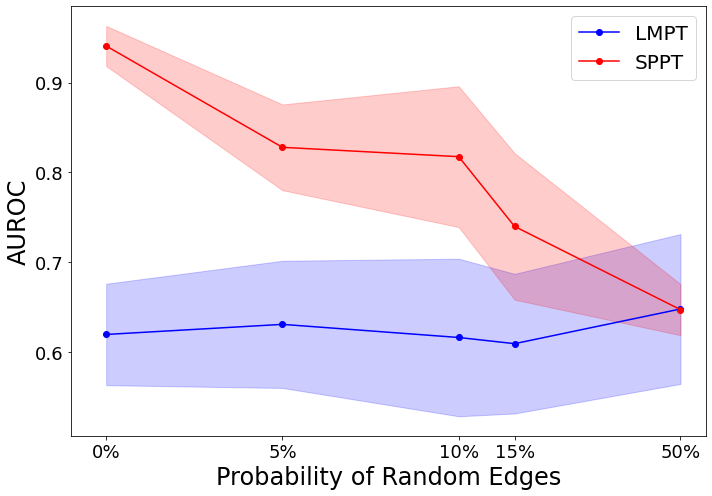

In [11]:
fig, ax_PT = plt.subplots(nrows=1, ncols=1, figsize=(10,7), sharex=True, sharey=True)

colors = {'GGML': 'red', 'MLM': 'blue'}

for ax, n in ((ax_PT, 'PT'),):
#     ax.set_title(f"Zero-shot FT with Noisy Graphs", fontsize=28)
    
    for s in ('MLM', 'GGML'):
        ax.plot(Xs, Y_means[(n, s)], color=colors[s], label='LMPT' if s == 'MLM' else 'SPPT', marker='o')
        ax.fill_between(
            Xs, Y_means[(n, s)] - Y_errs[(n, s)], Y_means[(n, s)] + Y_errs[(n, s)], color=colors[s], alpha=0.2,
        )
        
    ax.set_xlabel('Probability of Random Edges', fontsize=24)
    ax.set_ylabel('AUROC', fontsize=24)
    
ax_PT.set_xscale('symlog', linthresh=1e-1)

ax_PT.set_xticks(Xs)
ax_PT.set_xticklabels([f"{100*x:.0f}%" for x in Xs], fontsize=18)

ax_PT.tick_params(axis='y', labelsize=18)

ax_PT.set_xlim(-0.01, 0.6)
ax_PT.legend(fontsize=20)

plt.tight_layout()